In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F
from torch.autograd import grad
from torch import optim

In [2]:
# Transformations applied to each image
my_transforms = [transforms.ToTensor()]
transform_normalize = True
if transform_normalize:
    my_transforms.append(transforms.Normalize((0.5,), (0.5,)))
transform = transforms.Compose(my_transforms)

# Load FashionMNIST data
train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Data loaders
train_loader = DataLoader(train_data, batch_size=600, shuffle=True) # 100 batches
test_loader = DataLoader(test_data, batch_size=100, shuffle=False) # 100 batches

In [3]:
class SimpleNet(nn.Module):
    def __init__(self, n_classes=10):
        super(SimpleNet, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, n_classes)
        )

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        return self.fc(x)
    
class LeNet(nn.Module):

    def __init__(self, n_classes = 10):
        super(LeNet, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 6, 5, padding=2),
            nn.Conv2d(6, 16, 5),
            nn.Linear(16*5*5, 120),
            nn.Linear(120, 84)
        )
        self.classifier = nn.Sequential(nn.Linear(84, n_classes))

        # self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        # self.conv2 = nn.Conv2d(6, 16, 5)
        # self.fc1   = nn.Linear(16*5*5, 120)
        # self.fc2   = nn.Linear(120, 84)
        # self.fc3   = nn.Linear(84, n_classes)

    def forward(self, x, return_features = False):
        f = self.feature_extractor(x)
        y = self.classifier(f)
        if return_features:
            return y, f
        return y


In [4]:
def power_iteration_efficient(model, dataloader, criterion, num_iterations=10, n=10):
    device = next(model.parameters()).device
    vec = torch.randn(sum(p.numel() for p in model.parameters()), device=device)
    vec = vec / torch.norm(vec)

    for _ in range(num_iterations):
        Hv = torch.zeros_like(vec)
        for batch_id, (data, target) in enumerate(dataloader):
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            grads = grad(loss, model.parameters(), create_graph=True, retain_graph=True)
            grad_vec = torch.cat([g.contiguous().view(-1) for g in grads])

            Hv_contrib = compute_hessian_vector_product(grad_vec, model.parameters(), vec)
            Hv += Hv_contrib

            if batch_id > n:
              break
        Hv /= n
        lambda_ = torch.dot(Hv, vec)
        vec = Hv / torch.norm(Hv)
    return lambda_, vec

def compute_hessian_vector_product(grad_vec, parameters, vec):
    jacobian_vec_product = grad(grad_vec, parameters, grad_outputs=vec, retain_graph=True)
    return torch.cat([jvp.contiguous().view(-1) for jvp in jacobian_vec_product])

def fim_diag_batch(network: nn.Module, criterion, batch):
    device = next(network.parameters()).device
    p = len(nn.utils.parameters_to_vector(network.parameters()))
    n = len(batch)
    fisher_diag_info = torch.zeros(p).to(device)
    network.zero_grad()
    X, y = batch
    X, y = X.to(device), y.to(device)
    loss = criterion(network(X), y) / n
    loss.backward()
    for i, param in enumerate(network.parameters()):
        fisher_diag_info[i] += torch.sum(param.grad ** 2)
    fisher_trace = torch.sum(fisher_diag_info)
    return fisher_diag_info, fisher_trace

def fim_diag_point(network: nn.Module, criterion, x, y):
    device = next(network.parameters()).device
    p = len(nn.utils.parameters_to_vector(network.parameters()))
    fisher_diag_info = torch.zeros(p)
    network.zero_grad()
    X, y = torch.unsqueeze(x, 0), torch.unsqueeze(y, 0)
    X, y = X.to(device), y.to(device)
    loss = criterion(network(X), y)
    loss.backward()
    for i, param in enumerate(network.parameters()):
        fisher_diag_info[i] += torch.sum(param.grad ** 2).cpu()
    fisher_trace = torch.sum(fisher_diag_info)
    return fisher_diag_info, fisher_trace

In [5]:
def do_perturb_and_shrink(model, alpha, noise_std, threshold_norm_level=0.8):
    with torch.no_grad():
        for p in model.parameters():
            #norm = p.grad.norm()

            #threshold = torch.quantile(norm.flatten(), threshold_norm_level)
            # threshold = torch.quantile(norm, threshold_norm_level)
            #mask = norm >= threshold

            if p.grad is not None:
                gradients = p.grad.flatten()
                threshold = torch.quantile(gradients, threshold_norm_level)
                mask = (gradients >= threshold).reshape_as(p.grad)

                p.data[mask] = alpha * p.data[mask] + (1 - alpha) * torch.randn_like(p.data[mask]) * noise_std

In [13]:
def train_model(model, train_loader, test_loader, optimizer, criterion, epochs, device=torch.device("cpu"),
                perturb_and_shrink=False, every_batch=100, perturb_threshold=1.0, alpha_perturb=0.9, noise_std=0.01, threshold_norm_level=0.8,
                fisher_penalty=False, fisher_gamma=0.0):
    train_accuracies = []
    test_accuracies = []
    top_eigenvalues = []
    train_losses = []
    train_fishers = []

    print("Start training")

    for epoch in range(epochs):

        train_accuracy, train_loss, losses, fishers, eigens = do_epoch(model, train_loader, criterion, optimizer, device, every_batch, perturb_and_shrink,
                                                             perturb_threshold, alpha_perturb, noise_std, threshold_norm_level,
                                                             fisher_penalty, fisher_gamma)
        train_accuracies.append(train_accuracy)
        top_eigenvalues.extend(eigens)
        test_accuracy = test_model(model, test_loader, criterion, device)
        test_accuracies.append(test_accuracy)
        train_losses.extend(losses)
        train_fishers.extend(fishers)

        print(f'Epoch: {epoch} Training Loss: {train_loss} Training Fisher: {fishers[-1]} '
              f'Train Accuracy: {train_accuracy} Test Accuracy: {test_accuracy}')

        if test_accuracy > 85:
            break
        
    print(f"Ended training at {epoch}")

    return top_eigenvalues, train_losses, train_fishers, train_accuracies, test_accuracies

def do_epoch(model, train_loader, criterion, optimizer, device, every_batch=100, 
             perturb_and_shrink=False, perturb_threshold=1.0, alpha_perturb=0.9, noise_std=0.01, threshold_norm_level=0.8,
             fisher_penalty=False, fisher_gamma=0.0):
    model.train()
    total_loss, correct, total = 0, 0, 0
    running_loss = []
    losses = []
    running_fishers = []
    fishers = []
    eigens = []
    exp_eos = 2 / optimizer.param_groups[-1]['lr']
    for batch_idx, (data, target) in enumerate(train_loader):

        data, target = data.to(device), target.to(device)
        _, fisher = fim_diag_batch(model, criterion, (data, target))
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        if fisher_penalty:
            loss += fisher_gamma * fisher
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)

        running_loss.append(loss.item())
        running_fishers.append(fisher.cpu())

        if every_batch and (batch_idx + 1) % every_batch == 0:
            eigen = do_action(model, train_loader, criterion, perturb_and_shrink, exp_eos, perturb_threshold, alpha_perturb, noise_std, threshold_norm_level)
            eigens.append(eigen.item())
            losses.append(np.mean(running_loss))
            fishers.append(np.mean(running_fishers))
            print(f"Batch {batch_idx+1}: Top Eigenvalue = {eigen.item()}: MeanFisher = {fishers[-1]}")

        
    return 100. * correct / total, total_loss / len(train_loader), losses, fishers, eigens

def do_action(model, train_loader, criterion, perturb_and_shrink, exp_eos, perturb_threshold=1.0, alpha_perturb=0.9, noise_std=0.01, threshold_norm_level=0.8):

    print("Computing Hv")
    lambda_, _ = power_iteration_efficient(model, train_loader, criterion)

    if perturb_and_shrink and lambda_.item() > perturb_threshold * exp_eos:
        print("Peturb and shrink")
        do_perturb_and_shrink(model, alpha=alpha_perturb, noise_std=noise_std, threshold_norm_level=threshold_norm_level)

    return lambda_
    

def test_model(model, test_loader, criterion, device):
    model.eval()
    test_loss, correct = 0, 0
    n = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            n += 1

    test_loss /= n
    accuracy = 100. * correct / len(test_loader.dataset)
    return accuracy

In [14]:
def repeat_experiment(train_loader, test_loader, device, seeds, lrs, every_batches, with_vanilla, with_perturb_and_shrink, threshold_levels, alpha_perturbs, noise_stds, threshold_norm_levels, with_fisher_penalty, fisher_gammas):

    what_perturb = f"{len(every_batches)}x{len(threshold_levels)}x{len(alpha_perturbs)}x{len(noise_stds)}x{len(threshold_norm_levels)}" if with_perturb_and_shrink else 0
    what = f"{len(seeds)}x{len(lrs)}x[{1 if with_vanilla else 0}+({what_perturb})+{len(fisher_gammas) if with_fisher_penalty else 0}]"

    print(f"Training {what} models")

    R = {}
    epochs = 20

    hyper_dict = {
        "perturb_and_shrink": None,
        "lr": None,
        "every_batch": None,
        "threshold_level": None,
        "alpha_perturb": None,
        "noise_std": None,
        "threshold_norm_level": None,
        "seed": None
    }

    for seed in seeds:

        for lr in lrs:

            if with_vanilla:
                print("vanilla")
                torch.manual_seed(seed=seed)
                model = SimpleNet()
                model.to(device)
                criterion = nn.CrossEntropyLoss()
                optimizer = optim.SGD(model.parameters(), lr=lr)
                top_eigenvalues, train_losses, train_fishers, train_accuracies, test_accuracies =  \
                    train_model(
                        model,
                        train_loader,
                        test_loader,
                        optimizer,
                        criterion,
                        epochs,
                        device,
                        perturb_and_shrink=False,
                    )
                
                hyper_dict["lr"], hyper_dict["seed"], hyper_dict["perturb_and_shrink"], hyper_dict["fisher_penalty"] = lr, seed , False, False
                hyper_dict["threshold_level"], hyper_dict["alpha_perturb"], hyper_dict["noise_std"], hyper_dict["threshold_norm_level"] = None, None, None, None
                
                R[f"vanilla lr={lr} s={seed}"] = (top_eigenvalues, train_losses, train_fishers, train_accuracies, test_accuracies, hyper_dict.copy())

            if with_perturb_and_shrink:
                hyper_dict["perturb_and_shrink"] = True

                for every_batch in every_batches:
                    hyper_dict["every_batch"] = every_batch
                    for threshold_level in threshold_levels:
                        hyper_dict["threshold_level"] = threshold_level
                        for alpha_perturb in alpha_perturbs:
                            hyper_dict["alpha_perturb"] = alpha_perturb
                            for noise_std in noise_stds:
                                hyper_dict["noise_std"] = noise_std
                                for threshold_norm_level in threshold_norm_levels:
                                    hyper_dict["threshold_norm_level"] = threshold_norm_level
                                    
                                    torch.manual_seed(seed=seed)
                                    model = SimpleNet()
                                    model.to(device)
                                    criterion = nn.CrossEntropyLoss()
                                    optimizer = optim.SGD(model.parameters(), lr=lr)

                                    exp_name = f"lr={lr} eb={every_batch} thr={threshold_level} a={alpha_perturb} std={noise_std} thr_norm={threshold_norm_level} s={seed}"
                                    print(exp_name)

                                    top_eigenvalues, train_losses, train_accuracies, test_accuracies =  \
                                        train_model(
                                            model,
                                            train_loader,
                                            test_loader,
                                            optimizer,
                                            criterion,
                                            epochs,
                                            device,
                                            True, # perturb_and_shrink=
                                            every_batch, threshold_level, alpha_perturb, noise_std, threshold_norm_level
                                        )

                                    R[exp_name] = (top_eigenvalues, train_losses, train_accuracies, test_accuracies, hyper_dict.copy())
            
            if with_fisher_penalty:

                for every_batch in every_batches:
                    hyper_dict["every_batch"] = every_batch
                    for fisher_gamma in fisher_gammas:
                        hyper_dict["fisher_gamma"] = fisher_gamma

                        exp_name = f"lr={lr} eb={every_batch} fg={fisher_gamma} s={seed}"
                        print(exp_name)

                        torch.manual_seed(seed=seed)
                        model = SimpleNet()
                        model.to(device)
                        criterion = nn.CrossEntropyLoss()
                        optimizer = optim.SGD(model.parameters(), lr=lr)
                        top_eigenvalues, train_losses, train_fishers, train_accuracies, test_accuracies =  \
                            train_model(
                                model,
                                train_loader,
                                test_loader,
                                optimizer,
                                criterion,
                                epochs,
                                device,
                                perturb_and_shrink=False,
                                fisher_penalty=True,
                                fisher_gamma=fisher_gamma
                            )
                
                        hyper_dict["lr"], hyper_dict["seed"], hyper_dict["perturb_and_shrink"], hyper_dict["fisher_penalty"] = lr, seed , False, True
                        hyper_dict["threshold_level"], hyper_dict["alpha_perturb"], hyper_dict["noise_std"], hyper_dict["threshold_norm_level"] = None, None, None, None
                        
                        R[f"fisher lr={lr} s={seed}"] = (top_eigenvalues, train_losses, train_fishers, train_accuracies, test_accuracies, hyper_dict.copy())

    return R
            

In [18]:
R = repeat_experiment(train_loader, test_loader, "cuda", [0], [0.1, 0.05, 0.01], [10, 100], False, [0.1, 0.5, 1.0], [0.9, 0.5, 0.1], [0.001, 0.01, 0.1], [0.9, 0.5, 0.1])

Training 1x3x[1+2x3x3x3x3] models
vanilla
Start training
Batch 1: Fisher = 0.07826945185661316
Batch 2: Fisher = 0.06957535445690155
Batch 3: Fisher = 0.07483135908842087
Batch 4: Fisher = 0.08013753592967987
Batch 5: Fisher = 0.09704170376062393
Batch 6: Fisher = 0.10508067160844803
Batch 7: Fisher = 0.1029735654592514
Batch 8: Fisher = 0.13062672317028046
Batch 9: Fisher = 0.12741483747959137
Batch 10: Fisher = 0.1409820020198822
Batch 11: Fisher = 0.1493191421031952
Batch 12: Fisher = 0.1463327258825302
Batch 13: Fisher = 0.1535634845495224
Batch 14: Fisher = 0.1410394161939621
Batch 15: Fisher = 0.1457538902759552
Batch 16: Fisher = 0.1464947760105133
Batch 17: Fisher = 0.14729855954647064
Batch 18: Fisher = 0.13169065117835999
Batch 19: Fisher = 0.12680140137672424
Batch 20: Fisher = 0.12787997722625732
Batch 21: Fisher = 0.1280500441789627
Batch 22: Fisher = 0.13765019178390503
Batch 23: Fisher = 0.15172070264816284
Batch 24: Fisher = 0.16259373724460602
Batch 25: Fisher = 0.1296

In [15]:
R = repeat_experiment(train_loader, test_loader, "cuda", [0, 1], [0.1, 0.05, 0.01], [10, 100], True, False, None, None, None, None, True, [0.1, 1.0, 10.0])

Training 2x3x[1+(what_perturb)+3] models
vanilla
Start training
Computing Hv
Batch 100: Top Eigenvalue = 24.670307159423828: MeanFisher = 0.5090324282646179
Epoch: 0 Training Loss: 1.0777763372659683 Training Fisher: 0.5090324282646179 Train Accuracy: 63.78 Test Accuracy: 75.55
Computing Hv


In [9]:
import pickle 

for seed in [0,1,2]:

    for lr in [0.1, 0.05, 0.01, 0.005, 0.001]:

        for every_batch in [50, 100]:

            long_R = repeat_experiment(train_loader, test_loader, "cuda", [seed], [lr], [every_batch], [0.1, 0.2, 0.5, 1.0], [0.99, 0.9, 0.75, 0.5, 0.1], [0.001, 0.01, 0.05, 0.1], [0.99, 0.9, 0.75, 0.5, 0.25, 0.1])

            with open(f'longR_{lr}_s{seed}_eb{every_batch}.pkl', 'wb') as f:
                pickle.dump(long_R, f)
        
#with open('saved_dictionary.pkl', 'rb') as f:
#    loaded_dict = pickle.load(f)


Training 2x5x[1+2x4x5x4x6] models
vanilla
Start training
Computing Hv
Batch 100: Top Eigenvalue = 24.670307159423828
Epoch: 0 Training Loss: 1.0777763372659683 Train Accuracy: 63.78 Test Accuracy: 75.55
Computing Hv
Batch 100: Top Eigenvalue = 25.00946044921875
Epoch: 1 Training Loss: 0.6035859796404839 Train Accuracy: 77.665 Test Accuracy: 78.98
Computing Hv
Batch 100: Top Eigenvalue = 25.783349990844727
Epoch: 2 Training Loss: 0.5197786632180214 Train Accuracy: 80.97166666666666 Test Accuracy: 81.08
Computing Hv
Batch 100: Top Eigenvalue = 20.898101806640625
Epoch: 3 Training Loss: 0.49237670838832853 Train Accuracy: 81.955 Test Accuracy: 82.8
Computing Hv
Batch 100: Top Eigenvalue = 26.058704376220703
Epoch: 4 Training Loss: 0.4499789008498192 Train Accuracy: 83.62666666666667 Test Accuracy: 82.99
Computing Hv
Batch 100: Top Eigenvalue = 22.725914001464844
Epoch: 5 Training Loss: 0.4334301820397377 Train Accuracy: 84.26833333333333 Test Accuracy: 83.5
Computing Hv
Batch 100: Top Eig

KeyboardInterrupt: 

In [7]:
R = repeat_experiment(train_loader, test_loader, "cuda", [0], [0.1], [50, 100], [0.1, 0.5, 1.0], [0.9, 0.5, 0.1], [0.001, 0.01, 0.1], [0.75])

Training 1x1x[1+2x3x3x3x1] models
vanilla
Start training
Computing Hv
Batch 100: Top Eigenvalue = 24.670307159423828
Epoch: 0 Training Loss: 1.0777763372659683 Train Accuracy: 63.78 Test Accuracy: 75.55
Ended training at 0
lr=0.1 eb=50 thr=0.1 a=0.9 std=0.001 thr_norm=0.75 s=0
Start training
Computing Hv
Peturb and shrink
Batch 50: Top Eigenvalue = 23.89517593383789
Computing Hv
Peturb and shrink
Batch 100: Top Eigenvalue = 26.419055938720703
Epoch: 0 Training Loss: 1.0849788308143615 Train Accuracy: 63.528333333333336 Test Accuracy: 71.7
Computing Hv
Peturb and shrink
Batch 50: Top Eigenvalue = 33.55876541137695
Computing Hv
Peturb and shrink
Batch 100: Top Eigenvalue = 26.934040069580078
Epoch: 1 Training Loss: 0.622580680847168 Train Accuracy: 77.035 Test Accuracy: 75.11
Ended training at 1
lr=0.1 eb=50 thr=0.1 a=0.9 std=0.01 thr_norm=0.75 s=0
Start training
Computing Hv
Peturb and shrink
Batch 50: Top Eigenvalue = 23.89517593383789
Computing Hv
Peturb and shrink
Batch 100: Top Eige

In [9]:
R = repeat_experiment(train_loader, test_loader, "cuda", [0], [0.01], [50, 100], [0.1, 0.5, 1.0], [0.9], [0.001, 0.01, 0.1], [0.75])

Training 1x1x[1+2x3x1x3x1] models
vanilla
Start training
Computing Hv
Batch 100: Top Eigenvalue = 7.090348243713379
Epoch: 0 Training Loss: 2.138529222011566 Train Accuracy: 34.99166666666667 Test Accuracy: 48.35
Computing Hv
Batch 100: Top Eigenvalue = 16.08660125732422
Epoch: 1 Training Loss: 1.6472897183895112 Train Accuracy: 54.405 Test Accuracy: 59.39
Computing Hv
Batch 100: Top Eigenvalue = 28.397005081176758
Epoch: 2 Training Loss: 1.1923940402269364 Train Accuracy: 66.01 Test Accuracy: 69.11
Computing Hv
Batch 100: Top Eigenvalue = 32.40879440307617
Epoch: 3 Training Loss: 0.9308666968345642 Train Accuracy: 71.50166666666667 Test Accuracy: 71.87
Computing Hv
Batch 100: Top Eigenvalue = 37.28718566894531
Epoch: 4 Training Loss: 0.7998313957452774 Train Accuracy: 73.485 Test Accuracy: 73.38
Computing Hv
Batch 100: Top Eigenvalue = 41.784149169921875
Epoch: 5 Training Loss: 0.7293220514059067 Train Accuracy: 74.60666666666667 Test Accuracy: 74.45
Computing Hv
Batch 100: Top Eigenv

In [ ]:
R = repeat_experiment(train_loader, test_loader, "cuda", [0], [0.1, 0.05, 0.01], [10, 100], False, [0.1, 0.5, 1.0], [0.9, 0.5, 0.1], [0.001, 0.01, 0.1], [0.9, 0.5, 0.1])

In [21]:
R_vanilla = R.copy()

In [38]:
R.keys()

dict_keys(['vanilla lr=0.1 s=0', 'vanilla lr=0.05 s=0', 'vanilla lr=0.01 s=0'])

vanilla lr=0.1 s=0
vanilla lr=0.05 s=0
vanilla lr=0.01 s=0


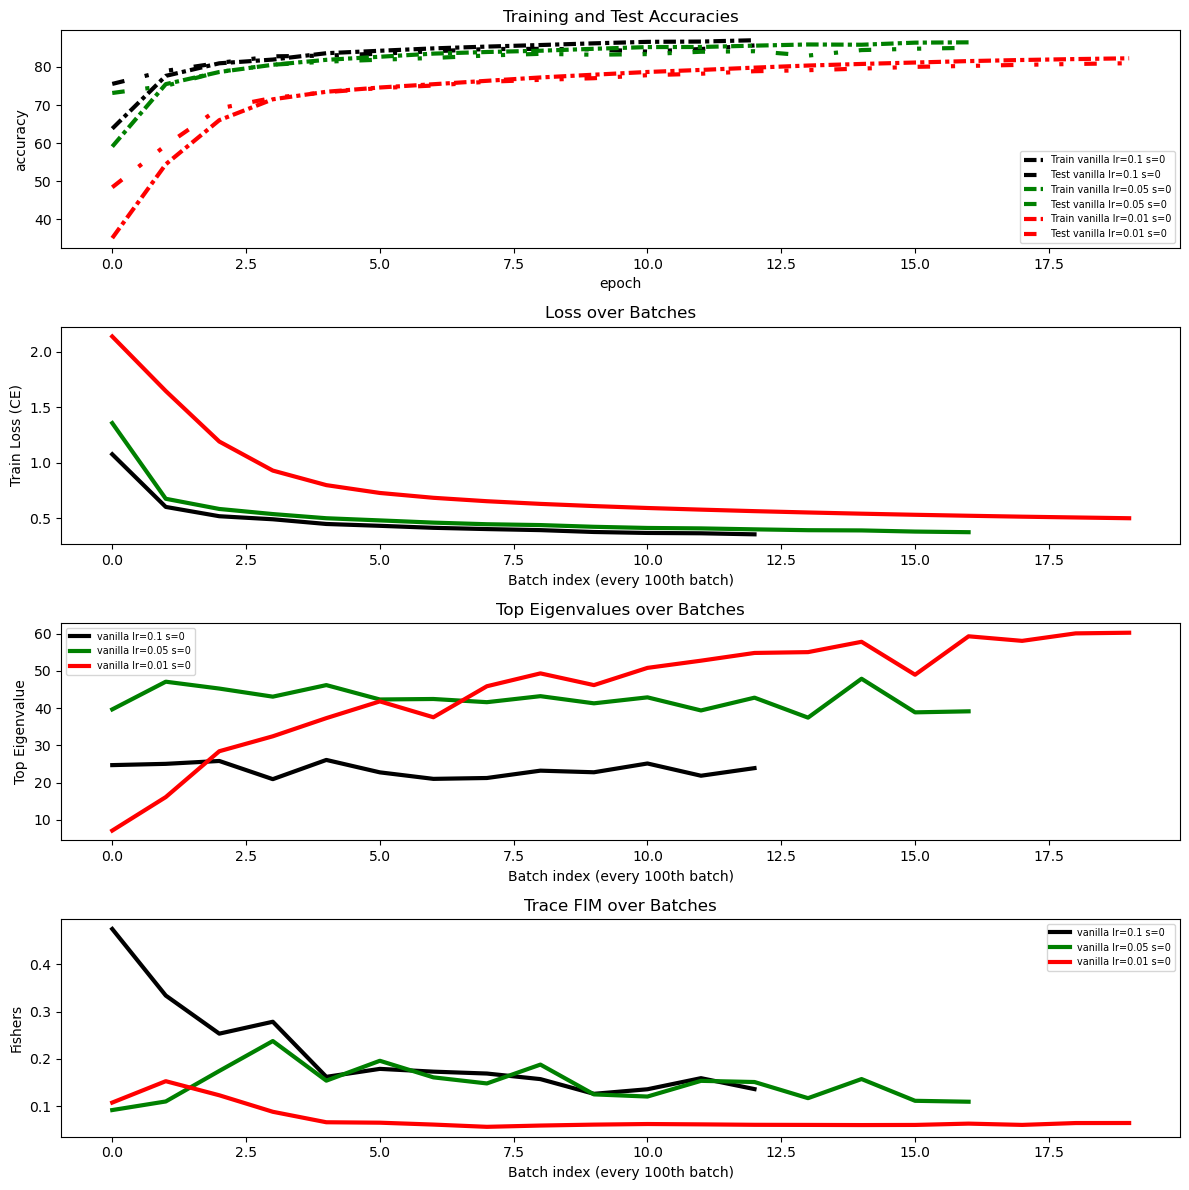

In [37]:
for key in R:
    if key.startswith("vanilla"):
        continue
    elif key.startswith("fisher"):
        R[key][-1]["fisher_penalty"] = True
    else:
        R[key][-1]["perturb_and_shrink"] = True

filter_dict = {
    "seed": 0,
    
}
R_filtered = {}
for key in R:
    print(key)
    if key.startswith("vanilla") or key.startswith("fisher"):
        R_filtered[key] = R[key]
        continue
    hyper_dict = R[key][-1]
    if all(filter_dict.get(hyperparam) == hyper_dict.get(hyperparam) for hyperparam in filter_dict):
        R_filtered[key] = R[key][0], R[key][1], R[key][2], R[key][3], R[key][-1].copy()

len(R_filtered)

plt.figure(figsize=(12, 12))

n_colours = len(R_filtered)
colours = do_colours(n_colours)

# Plot the accuracies and top eigenvalues
for i, key in enumerate(R_filtered):
  top_eigenvalues, losses, train_fishers, train_accuracies, test_accuracies, hyper_dict = R_filtered[key]

  train_marker, test_marker = '-', '--'
  linewidth = 1.0
  if hyper_dict["perturb_and_shrink"] == False:
    train_marker, test_marker = (0, (3, 1, 1, 1)), (0, (3, 5, 1, 5, 1, 5))
    linewidth = 3.0
  colour_marker = colours[i]

  plt.subplot(4, 1, 1)
  plt.plot(train_accuracies, color=colour_marker, linestyle=train_marker, linewidth=linewidth, label='Train ' + key)
  plt.plot(test_accuracies, color=colour_marker, linestyle=test_marker, linewidth=linewidth, label='Test ' + key)
  plt.xlabel("epoch")
  plt.ylabel("accuracy")
  plt.title('Training and Test Accuracies')
  plt.legend(fontsize = 'x-small')

  plt.subplot(4, 1, 2)
  plt.plot(losses, color=colour_marker, linewidth=linewidth, label=key)
  plt.title('Loss over Batches')
  plt.xlabel('Batch index (every 100th batch)')
  plt.ylabel('Train Loss (CE)')
  # plt.legend()

  plt.subplot(4, 1, 3)
  plt.plot(top_eigenvalues, color=colour_marker, linewidth=linewidth, label=key)
  plt.title('Top Eigenvalues over Batches')
  plt.xlabel('Batch index (every 100th batch)')
  plt.ylabel('Top Eigenvalue')
  plt.legend(fontsize = 'x-small')

  plt.subplot(4, 1, 4)
  plt.plot(train_fishers, color=colour_marker, linewidth=linewidth, label=key)
  plt.title('Trace FIM over Batches')
  plt.xlabel('Batch index (every 100th batch)')
  plt.ylabel('Fishers')
  plt.legend(fontsize = 'x-small')

plt.tight_layout()
plt.show()

In [23]:
for key in R:
    if key.startswith("vanilla"):
        continue
    else:
        R[key][-1]["perturb_and_shrink"] = True

In [19]:
def do_colours(n_colours):
    if n_colours <= 7:
        return ['k', 'g', 'r', 'c', 'm', 'y', 'b']
    else:
        assert n_colours <= 20
        cmap = plt.get_cmap('tab20')
        return [cmap(i) for i in range(n_colours)]

In [36]:
filter_dict = {
    "lr": 0.01,
    "alpha_perturb": 0.9,
    "noise_std": 0.1,
    "threshold_norm_level": 0.75,
    "seed": 0
}
R_filtered = {}
for key in R:
    print(key)
    if key.startswith("vanilla"):
        R_filtered[key] = R[key]
        continue
    hyper_dict = R[key][-1]
    if all(filter_dict.get(hyperparam) == hyper_dict.get(hyperparam) for hyperparam in filter_dict):
        R_filtered[key] = R[key][0], R[key][1], R[key][2], R[key][3], R[key][-1].copy()

len(R_filtered)

vanilla lr=0.01 s=0
lr=0.01 eb=50 thr=0.1 a=0.9 std=0.001 thr_norm=0.75 s=0
lr=0.01 eb=50 thr=0.1 a=0.9 std=0.01 thr_norm=0.75 s=0
lr=0.01 eb=50 thr=0.1 a=0.9 std=0.1 thr_norm=0.75 s=0
lr=0.01 eb=50 thr=0.5 a=0.9 std=0.001 thr_norm=0.75 s=0
lr=0.01 eb=50 thr=0.5 a=0.9 std=0.01 thr_norm=0.75 s=0
lr=0.01 eb=50 thr=0.5 a=0.9 std=0.1 thr_norm=0.75 s=0
lr=0.01 eb=50 thr=1.0 a=0.9 std=0.001 thr_norm=0.75 s=0
lr=0.01 eb=50 thr=1.0 a=0.9 std=0.01 thr_norm=0.75 s=0
lr=0.01 eb=50 thr=1.0 a=0.9 std=0.1 thr_norm=0.75 s=0
lr=0.01 eb=100 thr=0.1 a=0.9 std=0.001 thr_norm=0.75 s=0
lr=0.01 eb=100 thr=0.1 a=0.9 std=0.01 thr_norm=0.75 s=0
lr=0.01 eb=100 thr=0.1 a=0.9 std=0.1 thr_norm=0.75 s=0
lr=0.01 eb=100 thr=0.5 a=0.9 std=0.001 thr_norm=0.75 s=0
lr=0.01 eb=100 thr=0.5 a=0.9 std=0.01 thr_norm=0.75 s=0
lr=0.01 eb=100 thr=0.5 a=0.9 std=0.1 thr_norm=0.75 s=0
lr=0.01 eb=100 thr=1.0 a=0.9 std=0.001 thr_norm=0.75 s=0
lr=0.01 eb=100 thr=1.0 a=0.9 std=0.01 thr_norm=0.75 s=0
lr=0.01 eb=100 thr=1.0 a=0.9 std=0.1

In [38]:
def split_dict(d, splits=6):
    keys = list(d.keys())
    sub_dicts = [{} for _ in range(splits)]
    # key.startswith("vanilla")
    for sub_dict in sub_dicts:
        sub_dict['main'] = main_value
    
    # Exclude 'main' key from keys list
    if 'main' in keys:
        keys.remove('main')
    
    # Distribute remaining keys among sub-dictionaries
    for i, key in enumerate(keys):
        sub_dicts[i % splits][key] = d[key]
    
    return sub_dicts

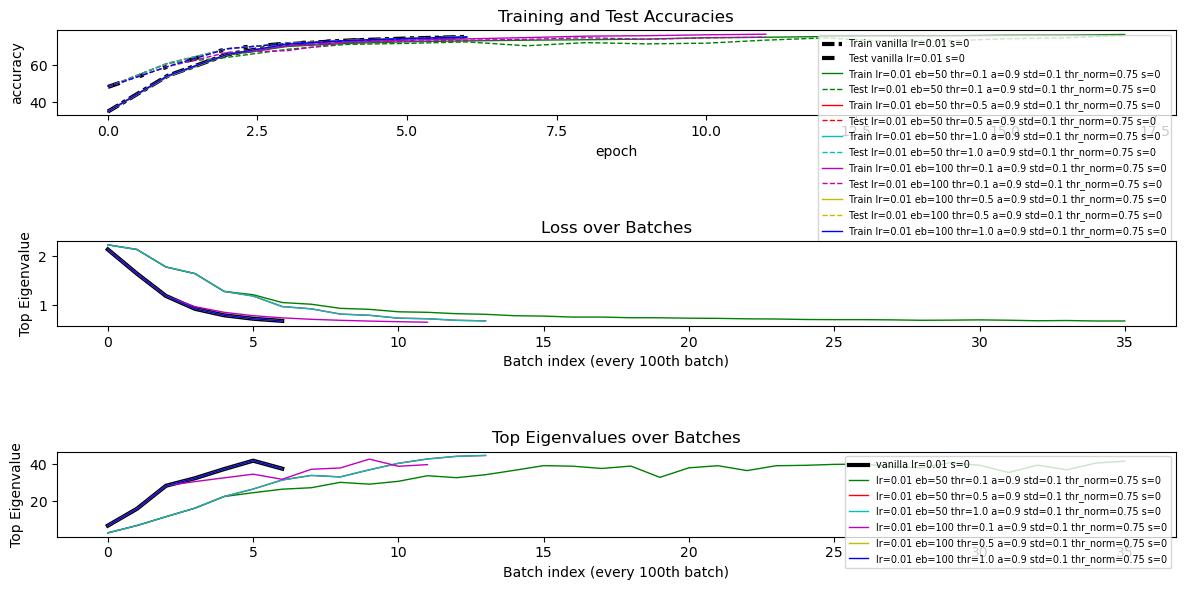

In [39]:
plt.figure(figsize=(12, 6))

n_colours = len(R_filtered)
colours = do_colours(n_colours)

# Plot the accuracies and top eigenvalues
for i, key in enumerate(R_filtered):
  top_eigenvalues, losses, train_accuracies, test_accuracies, hyper_dict = R_filtered[key]

  train_marker, test_marker = '-', '--'
  linewidth = 1.0
  if hyper_dict["perturb_and_shrink"] == False:
    train_marker, test_marker = (0, (3, 1, 1, 1)), (0, (3, 5, 1, 5, 1, 5))
    linewidth = 3.0
  colour_marker = colours[i]

  plt.subplot(3, 1, 1)
  plt.plot(train_accuracies, color=colour_marker, linestyle=train_marker, linewidth=linewidth, label='Train ' + key)
  plt.plot(test_accuracies, color=colour_marker, linestyle=test_marker, linewidth=linewidth, label='Test ' + key)
  plt.xlabel("epoch")
  plt.ylabel("accuracy")
  plt.title('Training and Test Accuracies')
  plt.legend(fontsize = 'x-small')

  plt.subplot(3, 1, 2)
  plt.plot(losses, color=colour_marker, linewidth=linewidth, label=key)
  plt.title('Loss over Batches')
  plt.xlabel('Batch index (every 100th batch)')
  plt.ylabel('Top Eigenvalue')
  # plt.legend()

  plt.subplot(3, 1, 3)
  plt.plot(top_eigenvalues, color=colour_marker, linewidth=linewidth, label=key)
  plt.title('Top Eigenvalues over Batches')
  plt.xlabel('Batch index (every 100th batch)')
  plt.ylabel('Top Eigenvalue')
  plt.legend(fontsize = 'x-small')

plt.tight_layout()
plt.show()